# Clustering with Machine Learning

One of the other major categories of machine learning is clustering. Unlike
supervised learning, clustering and unsupervised learning do not require targets or labels for the data. We can still use clustering with labeled data, however, but all inputs are treated as features. Clustering uncovers patterns in data based on the similarity of data points. There are several different methods for performing clustering, but they all rely on distances between data points.

- k-means clustering
- DBSCAN
- Hierarchical Clustering

## Using k-means Clustering

The k-means clustering method is widespread in data science, in part because it is simple to use and understand. In this method, we have one primary hyperparameter, k, which determines the
number of clusters.
- Initialize Cluster Centers: randomly select k points in the feature space as cluster centroids
- Calculate the distance of points to each cluster center with a metric and assign points to nearest cluster
- Readjust cluster centers based on average values of points in each cluster
- Repeat steps 2 and 3 until cluster centers change by a small amount (or not at all).

The initialization of the cluster centers can be done in an intelligent way to speed up convergence – we can initialize cluster centers so that they are far away from each other. The other steps are simple and easy to code by hand, but we can use k-means clustering easily through sklearn. Let's revisit our housing price data and see if it clusters into groups. First, we load the data:

In [4]:
import pandas as pd

df_path = "https://raw.githubusercontent.com/PacktPublishing/Practical-Data-Science-with-Python/main/16-Chapter-16/data/housing_data_sample.csv"

df = pd.read_csv(df_path, index_col='Id')
                 
df.head()

,LotArea,YearBuilt,FullBath,TotRmsAbvGrd,GarageArea,1stFlrSF,2ndFlrSF,SalePrice
Id,,,,,,,,
1,8450,2003,2,8,548,856,854,208500
2,9600,1976,2,6,460,1262,0,181500
3,11250,2001,2,6,608,920,866,223500
4,9550,1915,1,7,642,961,756,140000
5,14260,2000,2,9,836,1145,1053,250000


Since clustering algorithms are based on distances, we want to scale our data if the values are not already on the same scale or in the same units. We can do this using StandardScaler of sklearn and then fit a simple k-means model to the data:

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
km = KMeans()
km.fit(scaled_df)

KMeans()

By default, this uses eight clusters. However, we don't know the best number of
clusters without trying different values and comparing them. For that, we need to use metrics to measure performance.

### Clustering Metrics

We can use a few different metrics to compare the results of different values for k in k-means clustering (or to compare the results of other clustering algorithms).

- Within-cluster sum-of-squares (WCSS), also called inertia
- Silhouette score/co-efficient
- Calinski Harabasz (or Calinski Harabasz index)

In general, these methods aim to measure how well our clusters are grouping. The WCSS is simple and calculates the sum of the distance from each point to the center of the cluster. The center of a cluster (the centroid) is the average value of samples in the cluster.

A lower WCSS is better, but we typically use an "elbow" plot to pick the
ideal value. This method works well for spherical-shaped clusters, but for strange shapes (like ellipsoids) it does not work so well. Another way of describing these spherical cluster shapes is convex, meaning the boundaries of the clusters have a curvature that never bends inward.

The silhouette score measures a ratio involving the average distance between a
single point and all points in the same cluster (a) and the average distance between the single point and all points in the next nearest cluster (b). 
Equation ==> [(b-a)/(max(a,b))].

To get an average score for a cluster, we can take the average
silhouette score over all points in the cluster. This average measures how well each cluster has been formed. We can also average the silhouette score over the entire dataset for a single number to describe how well the entire dataset has clustered. The silhouette score can range from -1 to +1, and we get values for each individual point.

The last metric we'll talk about is the Calinski Harabasz score. This measures a ratio of the separation of cluster centroids to the spread of points in each cluster. Higher values mean tighter and more separated clusters, so we want higher values for this metric. It's a relative metric, so can be used to evaluate different clustering methods on the same data.

A few metrics work better for any shape of cluster (not just spherical), although those metrics require us to know the class labels of each datapoint (such as the Rand index, mutual information scores, and many others described in the sklearn documentation). Let's now take a look at using sklearn to optimize the k hyperparameter for k-means.

### Optimizing k in k-means


We'll first generate an "elbow" plot with the WCSS, or inertia values, to see
which value of k looks best. This value can be found from the model we fit with
km.inertia_. We can loop through a range of values for k and store the inertia values:


In [6]:
k_values = list(range(2, 20))

inertias = []

for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(scaled_df)
    inertias.append(km.inertia_)

Text(0, 0.5, 'WCSS')

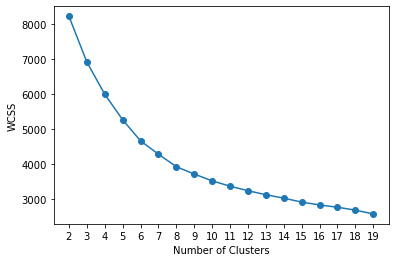

In [7]:
import matplotlib.pyplot as plt


plt.plot(k_values, inertias, marker="o")
plt.xticks(k_values)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

> This is called an "elbow" plot because ideally, we will see a kink in the plot where the WCSS or other metric's rate of improvement slows down and the line flattens out quickly. In the case above, there isn't a very clear elbow, suggesting more of a continuous spread of the data. However, we can choose a value of around 8 since it looks like there is a small change in slope there. We can also look at the change in slope for each point (the derivative) by using np.diff:

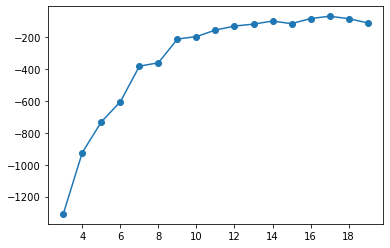

In [8]:
import numpy as np


plt.plot(k_values[1:], np.diff(inertias), marker = "o")

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score


silhouette_score(scaled_df, km.labels_)

0.2022671339736413

In [11]:
calinski_harabasz_score(scaled_df, km.labels_)

283.3176606044157

> We can use these other metrics in a loop as well and plot them like we did with
the WCSS. Another nice tool for doing all of this automatically is the yellowbrick
package, which can loop through several values for k, plot the results, and
automatically choose the best value for k:

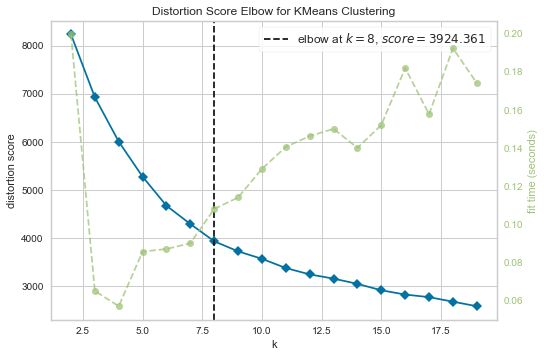

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=19), k=None)

In [12]:
from yellowbrick.cluster.elbow import kelbow_visualizer


kelbow_visualizer(KMeans(), scaled_df, k=(2, 20))

> By default, this uses distortion, which is the same as the WCSS (with the argument
metric='distortion'). We can also use metric='silhouette' or metric='calinski_
harabasz' for the other metrics we talked about.

We can see the same elbow was chosen at k=8. The plot also displays the time it takes
the algorithm to fit to the data, which generally goes up with more clusters (since
there are more distances to compute in each iteration).

If we try the other metrics such as silhouette score, we will find a different optimum k (3 for silhouette score and 2 for Calinski Harabasz). Ideally, we would want to see some of our metrics agree on a similar number for clusters. For example, the RbClust package in R uses 30 different metrics and takes the majority vote as the ideal number of clusters.


Last, let's look at a silhouette plot of our clusters. We'll go with three clusters since this was the ideal score from silhouette score and is the middle of the three values for k we found from our three metrics. We can visualize the silhouette scores for each of the points like so:

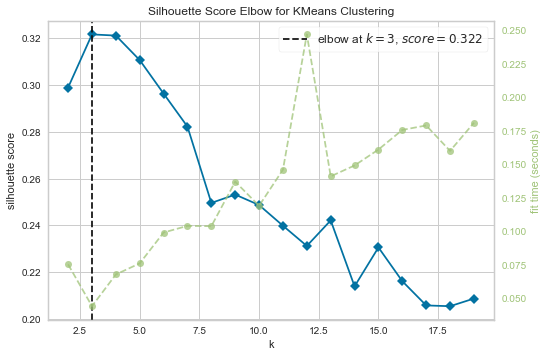

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=19), k=None, metric='silhouette')

In [16]:
from yellowbrick.cluster.elbow import kelbow_visualizer


kelbow_visualizer(KMeans(), scaled_df, k=(2, 20), metric = "silhouette")

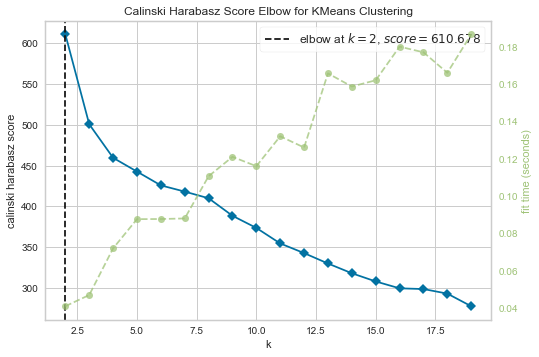

C:\Users\INNO\Anaconda3\envs\practical_data_science_env\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(n_clusters=19), k=None,
                 metric='calinski_harabasz')

In [17]:
from yellowbrick.cluster.elbow import kelbow_visualizer


kelbow_visualizer(KMeans(), scaled_df, k=(2, 20), metric = "calinski_harabasz")

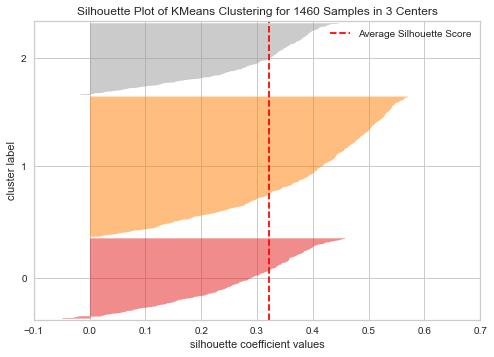

In [15]:
from yellowbrick.cluster import silhouette_visualizer


viz = silhouette_visualizer(KMeans(3, random_state=42), scaled_df)

Notice we are using the random_state argument here. There is a small amount of
randomness in the k-means algorithm when choosing the initial cluster centers,
although it shouldn't affect the final state in any major way. However, the exact labels for the clusters could change, so, setting the random state will ensure the cluster centers are the same every time

We can see the average score denoted by the dashed line, and the horizontal bars are the silhouette scores of each point. The points with negative scores are on the outskirts of a cluster and close to another cluster, while those with very high scores are close to their cluster center. The ideal silhouette plot would have all points with a high score and a sharp dropoff with a few, if any, points with low scores. Our clustering here looks decent, but not great. We can also see that the size of cluster 1 is much larger than the other two clusters.

### Examining the Clusters

We can examine our clusters in a few ways – numerically and visually. Numerically, we can get summary values, such as the average, for each of the clusters.

In [19]:
km = KMeans(3, random_state=42)
km.fit(scaled_df)

KMeans(n_clusters=3, random_state=42)

In [20]:
df_labels = df.copy()
df_labels['label'] = km.labels_


for label in range(3):
    print(f'cluster {label}:')
    print(df_labels[df_labels['label'] == label].mean(), '\n')
    

cluster 0:
LotArea          11100.957606
YearBuilt         1983.097257
FullBath             2.049875
TotRmsAbvGrd         7.945137
GarageArea         551.256858
1stFlrSF          1074.279302
2ndFlrSF           921.137157
SalePrice       223219.441397
label                0.000000
dtype: float64 

cluster 1:
LotArea           8717.477889
YearBuilt         1953.158345
FullBath             1.088445
TotRmsAbvGrd         5.596291
GarageArea         357.379458
1stFlrSF           980.592011
2ndFlrSF           181.263909
SalePrice       129434.780314
label                1.000000
dtype: float64 

cluster 2:
LotArea          13385.846369
YearBuilt         1993.477654
FullBath             1.955307
TotRmsAbvGrd         6.723464
GarageArea         611.659218
1stFlrSF          1618.027933
2ndFlrSF            28.399441
SalePrice       234358.013966
label                2.000000
dtype: float64 



> We first create a copy of our original DataFrame and add the labels to it. Then we loop through each cluster label and print the average value of points in that cluster using DataFrame masking. We also add a newline ('\n') so each group of results is separated by a blank line. The results look like this:

From this, we can see the first cluster (0) consists of more expensive houses with two stories (or floors). The second cluster (1) are cheaper, older houses. Finally, the last cluster appears to be newer, more expensive houses with a single story (floor).

Another way to examine our data is visualization. One way to do this would be with histograms or other visualization techniques we've learned throughout the book. For example, we could look at histograms of the sale price:

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

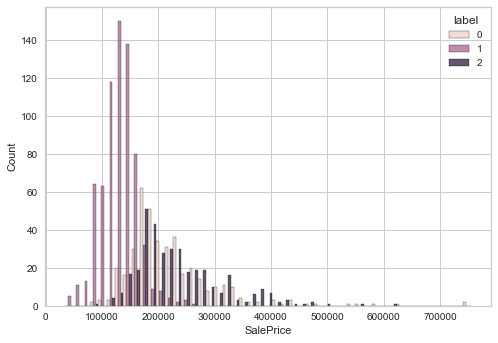

In [21]:
import seaborn as sns


sns.histplot(df_labels, x = 'SalePrice', hue = 'label', multiple = 'dodge')

This creates histograms for the sale price for each of the three clusters. Looking at certain elements can be helpful, but we can also use 2D and 3D plots to examine the data.

Since each data point has several dimensions, it's helpful to use dimensionality reduction to be able to visualize data well in two or three dimensions. We can use principal component analysis (PCA) to do this:

In [23]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)

pca_df = pca.fit_transform(scaled_df)

Text(0, 0.5, 'PCA Dimension 2')

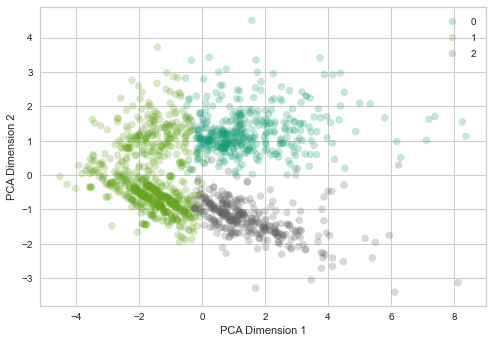

In [24]:
scatter = plt.scatter(pca_df[: , 0],
                      pca_df[: , 1],
                      c = km.labels_,
                      cmap = 'Dark2',
                      alpha = 0.25
                     )


plt.legend(*scatter.legend_elements())
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

We can see the clusters are not perfectly separated and there are some outliers. It even appears from this plot as though we might use four clusters, but remember we optimized k using our metrics. Instead of plotting with the PCA dimensions, we could also plot using two dimensions from the original or standardized data to see how the data groups along those dimensions. Or, we could use other dimensionality reduction techniques besides PCA.

> Lastly, we can also use yellowbrick to easily create a PCA plot similar to the above plot:

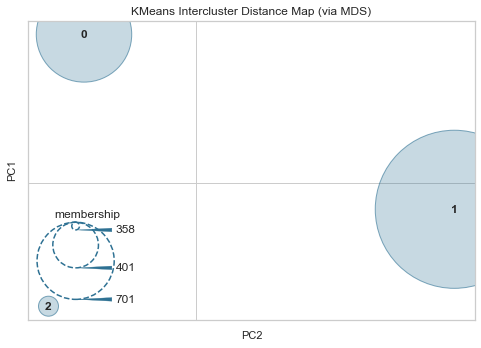

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=3, random_state=42),
                     random_state=42)

In [25]:
from yellowbrick.cluster import intercluster_distance


intercluster_distance(km, scaled_df, random_state = 42)

Instead of showing the raw data points, this shows circles for the cluster centers, with the size of the circle proportional to the number of points

We can see the same relationship of clusters as we had in our original PCA plot, with the sizes of the circles corresponding to the density of points we saw in our first plot as well. However, it's a little easier to read the size of a circle rather than guessing from the density of points.


Now that we've seen k-means, which is one of the canonical methods for clustering, let's look at a few other essential clustering methods.

## Hierarchical Clustering


Hierarchical clustering can operate in a bottom-up or top-down approach. The bottom-up approach starts with each point in its own cluster and joins the closest points into clusters based on distance metrics until all points are in one cluster.
The top-down approach starts with all points in one cluster and splits them until all points are in their own cluster.

In [26]:
from sklearn.cluster import AgglomerativeClustering


ac = AgglomerativeClustering(n_clusters=3)
ac.fit(scaled_df)

AgglomerativeClustering(n_clusters=3)

This sklearn class works almost the same as the k-means clustering algorithm, with a primary hyperparameter n_clusters. As with k-means and other distance-based algorithms, it's usually good to scale our data, so we used scaled_df. We can use the same metrics as before, like distortion (inertia, or WCSS), silhouette score, and Calinski Harabasz. We can use these with yellowbrick again to get the optimal number of clusters:

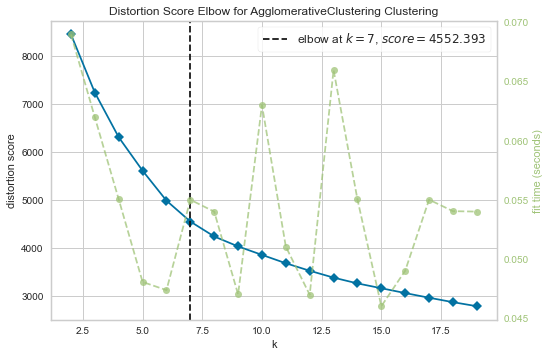

In [28]:
viz = kelbow_visualizer(AgglomerativeClustering(), scaled_df, k=(2,20))

We can see that the optimal number of clusters is similar to k-means using WCSS: 7 here, versus 8 for k-means. One big difference is the time to fit is shorter. This is because fewer distances need to be computed due to how the algorithm works.


The hierarchical clustering algorithm works by finding the closest points and joining them together as a cluster. Then it takes a distance metric between each cluster and connects the closest clusters until either the number of clusters has been met or all points have been grouped into a single cluster. To measure distance, we can use a few different methods:

- Single linkage: the distance between the closest points between clusters
- Complete (maximum) linkage: the biggest distance between points in clusters
- Average linkage: the distance between the centroids of clusters (average value of points in the clusters)
- Ward linkage: the sum of squared distances between each point in clusters

The default linkage argument or distance methodology with AggolmerativeClustering of sklearn is Ward (linkage='ward'), although it can
be any of ward, complete, average, or single. Often, there is not a huge difference between using the different linkage methods when working with larger datasets and ward works for most applications. However, average, complete, and ward linkage tend to yield more balanced dendrograms compared with other methods according to the ISLR book (https://www.statlearning.com/). Using Ward linkage also works well for spherical or convex clusters similar to k-means clustering, and using single linkage can capture strange cluster shapes.

> One other aspect of hierarchical clustering is the fact that we can plot dendrograms,
or tree diagrams. These show how points are joined together to make clusters. The sklearn documentation has an example showing how to do this with a custom
function (https://scikit-learn.org/stable/auto_examples/cluster/plot_
agglomerative_dendrogram.html), although we can simply use scipy:

Text(0, 0.5, 'depth')

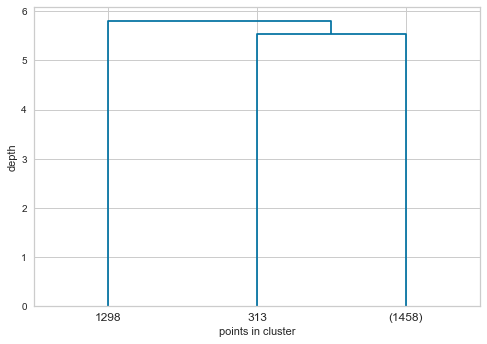

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage


dendrogram(linkage(scaled_df), truncate_mode = 'lastp', p = 3)
plt.xlabel('points in cluster')
plt.ylabel('depth')

The y axis in the dendrogram is the distance between points. The horizontal lines show when two clusters, which have a distance corresponding to the y value at the horizontal line, are joined together. We can also see that the number of points in the clusters is similar to what we saw from k-means.



## DBSCAN


Another clustering method that can work well for strange cluster shapes is DBSCAN, which stands for Density-Based Spatial Clustering of Applications with Noise. The algorithm is completely different from k-means or hierarchical clustering. With DBSCAN, our clusters are composed of core points and non-core points. Core points are all within a distance, epsilon (eps in the sklearn parameters), of at least n points in the same cluster (n is the min_samples parameter in the sklearn function). Then, any other points within the distance epsilon of the core points are also in the cluster.


If any points are not within the epsilon distance of any core points, these are outliers. This algorithm assumes we have some dead space between samples, so our clusters must have at least some separation. We can also tune the eps and min_samples hyperparameters to optimize clustering metrics.


The min_samples hyperparameter should generally be between the number of
features and two times the number of features, with a higher value for noisier data.
A higher number of core points means we need denser groups of points to create
clusters. For eps, we can calculate the average distance between points and their min_samples nearest neighbors, plot these values in order, and then find a "knee" or "elbow" in the plot (the point of maximum curvature). We can get the average distances between points and their nearest n neighbors with sklearn like this:

Text(0, 0.5, 'average distance to 16 neighbors')

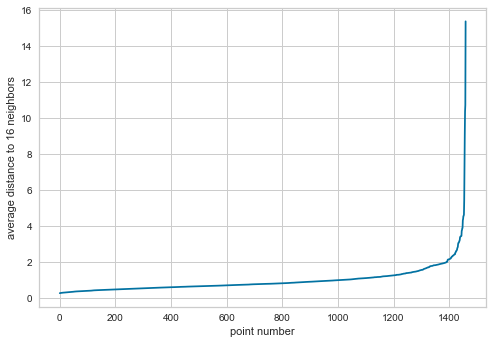

In [32]:
from sklearn.neighbors import NearestNeighbors


core_points = scaled_df.shape[1] * 2

nn = NearestNeighbors(n_neighbors=core_points + 1)

nn = nn.fit(scaled_df)

distances, neighbors = nn.kneighbors(scaled_df)

average_distances = distances[:, 1:].mean(axis=1)

average_distances.sort()

plt.plot(average_distances)
plt.xlabel('point number')
plt.ylabel(f'average distance to {core_points} neighbors')

- We set our core_points variable to be two times the number of features (the number of columns in our DataFrame) since our dataset is small and probably noisy

- We calculate the average distance to core_points neighbors with each point. We add 1 because the first nearest neighbor is the point itself with a distance of 0.

- The NearestNeighbors object is fit to the data (overwriting the nn variable with the fitted NearestNeighbors object).

- Distances between neighbors and the indices of the nearest neighbors to each point are extracted with nn.kneighbors.

- We take the average distance to the core_points nearest neighbors (ignoring the first nearest neighbor or self-distance of 0 by indexing with [:, 1:]) and sort this from least to greatest.

In [35]:
from kneed import KneeLocator


kneedle = KneeLocator(range(average_distances.shape[0]),
                     average_distances,
                      curve='convex',
                      direction='increasing'
                     )


eps = average_distances[kneedle.knee]

In [36]:
from sklearn.cluster import DBSCAN


db = DBSCAN(eps=eps, min_samples=core_points, n_jobs=-1)

db.fit(scaled_df)

DBSCAN(eps=2.434228927106824, min_samples=16, n_jobs=-1)

Note that we are also using n_jobs=-1 here to use all available processors in parallel.


We can look at the number of clusters by looking at the unique values in the labels with np.unique(db.labels_). This shows us that we only have one cluster (label 0) and outliers (label -1). If we decrease our eps or core points values, we can get more than a single cluster. However, some metrics, such as the silhouette score, will decrease if we increase the number of clusters. Of course, we could try other methods for optimizing eps and min_samples, such as calculating metrics like WCSS for a variety of hyperparameter values.

>We  can see that with DBSCAN, we can use it not only for clustering, but also for
outlier detection. However, one of the drawbacks of DBSCAN is that it assumes a
uniform density of clusters, which is not always true. Several people have made
improvements to DBSCAN, such as DMDBSCAN (https://iopscience.iop.org/
article/10.1088/1755-1315/31/1/012012/pdf) and many others. One algorithm
similar to DBSCAN in sklearn is OPTICS, which uses a more complex method of
finding clusters similar to DBSCAN. However, OPTICS does not work better for our
small dataset here, at least based on silhouette score.

We can see that with DBSCAN, we can use it not only for clustering, but also for outlier detection. However, one of the drawbacks of DBSCAN is that it assumes a uniform density of clusters, which is not always true. Several people have made improvements to DBSCAN, such as DMDBSCAN (https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) and many others. One algorithm
similar to DBSCAN in sklearn is OPTICS, which uses a more complex method of
findin






g clusters similar to DBSCAN. However, OPTICS does not work better for our small dataset here, at least based on silhouette score.